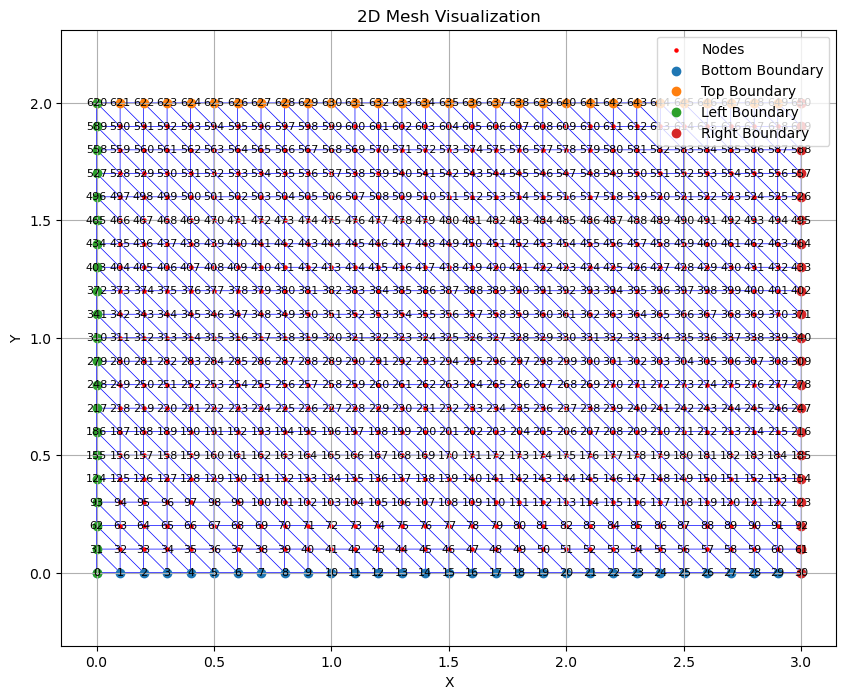

In [38]:
import numpy as np
import triangle
import matplotlib.pyplot as plt


class Mesh2D:
    def __init__(self, x_min=0.0, x_max=1.0, y_min=0.0, y_max=1.0, mesh_size=0.1, structured=True, nx=None, ny=None):
        """
        Initialize a 2D mesh with either structured or unstructured configuration.
        :param x_min: Minimum x-coordinate.
        :param x_max: Maximum x-coordinate.
        :param y_min: Minimum y-coordinate.
        :param y_max: Maximum y-coordinate.
        :param mesh_size: Desired element size (for unstructured).
        :param structured: True for structured mesh, False for unstructured.
        :param nx: Number of divisions along x (for structured).
        :param ny: Number of divisions along y (for structured).
        """
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.mesh_size = mesh_size
        self.structured = structured
        self.nx = nx if nx else int((x_max - x_min) / mesh_size)
        self.ny = ny if ny else int((y_max - y_min) / mesh_size)
        self.nodes_coords = None
        self.triangles = None
        self.boundary_nodes = None
        self.boundary_lines = None
        self.side_normals = None

        if structured:
            self._generate_structured_mesh()
        else:
            self._generate_unstructured_mesh()

    def _generate_structured_mesh(self):
        """
        Generate a structured 2D triangular mesh.
        """
        x = np.linspace(self.x_min, self.x_max, self.nx + 1)
        y = np.linspace(self.y_min, self.y_max, self.ny + 1)
        xx, yy = np.meshgrid(x, y)
        self.nodes_coords = np.column_stack([xx.ravel(), yy.ravel()])

        # Generate connectivity
        self.triangles = []
        for i in range(self.ny):
            for j in range(self.nx):
                n1 = i * (self.nx + 1) + j
                n2 = n1 + 1
                n3 = n1 + (self.nx + 1)
                n4 = n3 + 1
                self.triangles.append([n1, n2, n3])
                self.triangles.append([n2, n4, n3])
        self.triangles = np.array(self.triangles)

        # Boundary nodes
        self.boundary_nodes = {
            "bottom": np.arange(0, self.nx + 1),
            "top": np.arange(self.ny * (self.nx + 1), (self.ny + 1) * (self.nx + 1)),  # <-- Updated line
            "left": np.arange(0, (self.ny + 1) * (self.nx + 1), self.nx + 1),
            "right": np.arange(self.nx, (self.ny + 1) * (self.nx + 1), self.nx + 1)
        }


        # Boundary lines
        self.boundary_lines = {
            "bottom": [(n1, n2) for n1, n2 in zip(self.boundary_nodes["bottom"][:-1], self.boundary_nodes["bottom"][1:])],
            "top": [(n1, n2) for n1, n2 in zip(self.boundary_nodes["top"][:-1], self.boundary_nodes["top"][1:])],
            "left": [(n1, n2) for n1, n2 in zip(self.boundary_nodes["left"][:-1], self.boundary_nodes["left"][1:])],
            "right": [(n1, n2) for n1, n2 in zip(self.boundary_nodes["right"][:-1], self.boundary_nodes["right"][1:])]
        }

        # Include corner nodes in adjacent sides
        self._include_corners_in_boundary_lines()

    def _generate_unstructured_mesh(self):
        """
        Generate an unstructured 2D triangular mesh using the Triangle library.
        """
        vertices = np.array([
            [self.x_min, self.y_min],
            [self.x_max, self.y_min],
            [self.x_max, self.y_max],
            [self.x_min, self.y_max]
        ])
        segments = np.array([
            [0, 1],
            [1, 2],
            [2, 3],
            [3, 0]
        ])
        geometry = {"vertices": vertices, "segments": segments}
        area_constraint = (self.mesh_size ** 2) * np.sqrt(3) / 4
        mesh = triangle.triangulate(geometry, f"pq30a{area_constraint}")

        self.nodes_coords = mesh["vertices"]
        self.triangles = mesh["triangles"]
        edges = mesh["segments"]

        # Boundary nodes
        self.boundary_nodes = {
            "bottom": set(edges[edges[:, 0] == 0].flatten()),
            "right": set(edges[edges[:, 0] == 1].flatten()),
            "top": set(edges[edges[:, 0] == 2].flatten()),
            "left": set(edges[edges[:, 0] == 3].flatten())
        }

        # Boundary lines
        self.boundary_lines = {
            side: [(n1, n2) for n1, n2 in zip(sorted(nodes)[:-1], sorted(nodes)[1:])]
            for side, nodes in self.boundary_nodes.items()
        }

        # Include corner nodes in adjacent sides
        self._include_corners_in_boundary_lines()

    def _include_corners_in_boundary_lines(self):
        """
        Ensure corner nodes are correctly included in boundary lines for adjacent sides.
        """
        corners = {
            (self.x_min, self.y_min): ("bottom", "left"),
            (self.x_max, self.y_min): ("bottom", "right"),
            (self.x_max, self.y_max): ("top", "right"),
            (self.x_min, self.y_max): ("top", "left")
        }
        for corner, sides in corners.items():
            corner_index = np.where((self.nodes_coords == corner).all(axis=1))[0][0]

            for side in sides:
                # Ensure the corner is part of the boundary node list
                if corner_index not in self.boundary_nodes[side]:
                    self.boundary_nodes[side] = np.append(self.boundary_nodes[side], corner_index)

                # Add the corner to the boundary line only if it is not already included
                side_lines = self.boundary_lines[side]
                if len(side_lines) > 0 and corner_index not in side_lines[-1]:
                    # Connect the corner node to the previous node in the same boundary
                    previous_node = self.boundary_nodes[side][-2]  # Second to last node
                    side_lines[-1] = (previous_node, corner_index)

    def compute_side_normals(self):
        """
        Compute normal vectors for side boundary elements.
        """
        normals = {}
        for side, lines in self.boundary_lines.items():
            side_normals = []
            for n1, n2 in lines:
                p1 = self.nodes_coords[n1]
                p2 = self.nodes_coords[n2]
                tangent = p2 - p1
                normal = np.array([-tangent[1], tangent[0]])  # Rotate 90 degrees
                normal /= np.linalg.norm(normal)
                side_normals.append(normal)
            normals[side] = side_normals
        self.side_normals = normals

    def visualize(self, show_node_numbers=False):
        """
        Visualize the mesh, boundary nodes, and optionally display node numbers.
        :param show_node_numbers: If True, display node numbers on the plot.
        """
        plt.figure(figsize=(10, 8))  # Increased figure size for clarity
        plt.triplot(self.nodes_coords[:, 0], self.nodes_coords[:, 1], self.triangles, color='blue', linewidth=0.5)
        plt.scatter(self.nodes_coords[:, 0], self.nodes_coords[:, 1], color='red', s=5, label='Nodes')
        
        # Highlight boundary nodes
        for side, nodes in self.boundary_nodes.items():
            plt.scatter(self.nodes_coords[list(nodes), 0], self.nodes_coords[list(nodes), 1], label=f'{side.capitalize()} Boundary')
        
        # Optionally display node numbers
        if show_node_numbers:
            for i, (x, y) in enumerate(self.nodes_coords):
                plt.text(x, y, str(i), fontsize=8, color='black', ha='center', va='center')
        
        plt.legend()
        plt.title("2D Mesh Visualization")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.axis("equal")
        plt.grid(True)
        plt.show()



# Example Usage
mesh = Mesh2D(x_min=0, x_max=3, y_min=0, y_max=2, mesh_size=0.1, structured=True)
mesh.compute_side_normals()
mesh.visualize(show_node_numbers=True)


In [39]:
mesh.boundary_nodes["top"]

array([620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632,
       633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645,
       646, 647, 648, 649, 650])

In [40]:
mesh.boundary_lines["top"]

[(620, 621),
 (621, 622),
 (622, 623),
 (623, 624),
 (624, 625),
 (625, 626),
 (626, 627),
 (627, 628),
 (628, 629),
 (629, 630),
 (630, 631),
 (631, 632),
 (632, 633),
 (633, 634),
 (634, 635),
 (635, 636),
 (636, 637),
 (637, 638),
 (638, 639),
 (639, 640),
 (640, 641),
 (641, 642),
 (642, 643),
 (643, 644),
 (644, 645),
 (645, 646),
 (646, 647),
 (647, 648),
 (648, 649),
 (649, 620)]